# Import and plot all the analytic computation and simple simulation


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tabulate import tabulate
from multiprocessing import Pool
import time
import importlib
from scipy.ndimage import uniform_filter1d

# import the C++ module
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend/')
import Gillespie_backend as backend
sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Analysis/')
import Old_Simulate_System as SimSys

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/super_simple_simulation/')

import Super_Simple_System as SSSys
import Super_Simple_Stochastic_Matrix as SSSMatrix

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Aging_Condensate/Analysis_cluster/Analysis_object/')
import Pair_Correlation_Function as PCF
importlib.reload(PCF)

<module 'Pair_Correlation_Function' from '/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Analysis/Pair_Correlation_Function.py'>

In [7]:
# define the unit of the gillespie :
R = 50
L = 100
Eb = -10.
kdiff = 0.000207352
size = 100
dangling = True
#V = 2*((L/6)**1.5/1**0.5*3/4*np.pi)
V = 4/3*np.pi*(L/6)**1.5
kdiff_estimate = 1/V

  Pmeet_dangling    Pmeet_loop      kunbind        kdiff    kdiff_estimate
----------------  ------------  -----------  -----------  ----------------
     0.000207352     0.0855245  4.53999e-05  0.000207352        0.00350864


(0.0, 0.2)

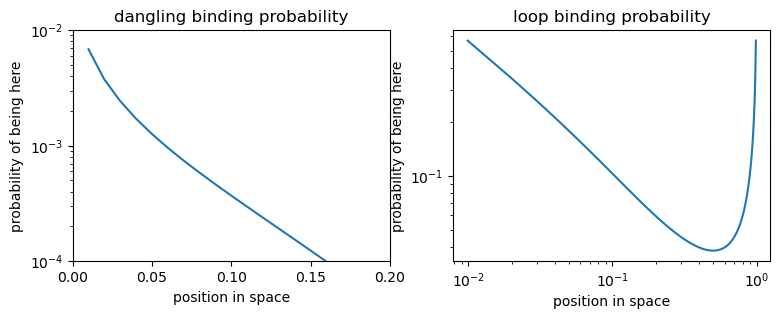

In [8]:
# Look at the dangling and loop probability distribution of meeting :
X0,Pmeet_dangling = SSSMatrix.PmeetArray(R,L,size,dangling = True)
X1,Pmeet_loop = SSSMatrix.PmeetArray(R,L,size,dangling = False)
fig,ax = plt.subplots(ncols=2,figsize=(9,3))
for i in range(2):
    ax[i].set_xlabel('position in space')
    ax[i].set_ylabel('probability of being here')
ax[0].set_title('dangling binding probability')
ax[1].set_title('loop binding probability')
ax[0].plot(X0,Pmeet_dangling)
ax[1].plot(X1,Pmeet_loop)
Prob = tabulate([[np.mean(Pmeet_dangling),np.mean(Pmeet_loop),np.exp(Eb),kdiff,kdiff_estimate]],headers=['Pmeet_dangling','Pmeet_loop','kunbind','kdiff','kdiff_estimate'])
print(Prob)
ax[0].set_yscale('log')
ax[1].set_yscale('log')
#ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylim(10**-4,10**-2)
ax[0].set_xlim(0,0.2)

In [9]:
# Stochastic matrix method for steady state
X,PMatrix = SSSMatrix.get_ss(R,L,kdiff,Eb,size,dangling)

In [10]:
sssys = SSSys.System(R,L,Eb,kdiff,size,dangling=dangling)
sssys.simulate_eq_distribution(10**6)
print(sssys.move)

[0.304721 0.347639 0.34764 ]


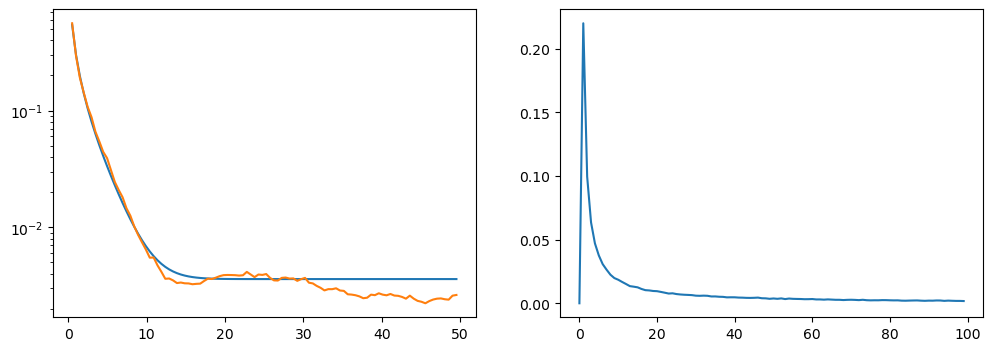

In [11]:
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot(X*R,PMatrix)
ax[0].plot(sssys.X(),sssys.PR)
ax[0].set_yscale('log')
ax[1].plot(np.linspace(0.,sssys.L,sssys.N_L_points,endpoint=False),sssys.PL)

In [12]:
print('probability normalization :'+str(np.sum(PMatrix)*R/size))
print('probability normalization :'+str(np.sum(sssys.PR)*R/size))
print('the average distance for a dangling bond : d = '+str(sssys.Mean_distance))

probability normalization :0.9999999999999997
probability normalization :0.9999999999999697
the average distance for a dangling bond : d = 10.776624233747741


# Perform a similar simulation using the 3D simulation in a 1D version with 1 linker

[0.0, 4.243408136318523]


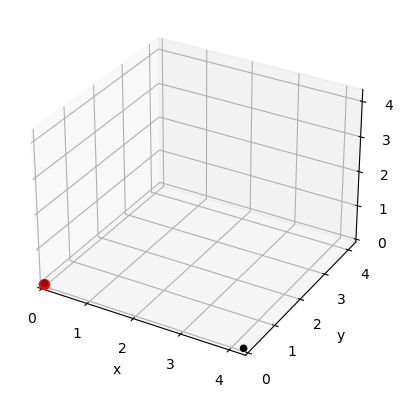

In [13]:
Sys = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=2,dimension=1)
Sys.Plot3DGillespie()
print([np.linalg.norm(r) for r in Sys.get_r()])

In [14]:
Sim = SimSys.Simulation(step_tot = 10**6,Gillespie = Sys)
Sim.simulate_eq_distribution()
print(Sim.move)

[0.406686 0.186627 0.       0.406687]


In [25]:
Sim.time

array([1.14027050e+03, 1.76470056e+03, 1.83370019e+03, ...,
       9.13160185e+09, 9.13165426e+09, 9.13165449e+09])

In [33]:
start_time = time.time()
X_1,Y_1 = PCF.compute_2_body_dist_prob(Sim.R)
end_time=time.time()
print(end_time-start_time)

start_time = time.time()
X_2,Y_2 = PCF.compute_pair_prob_function(Sim.R,Sim.time,num_bins=100,max_distance=10,dimension=1)
end_time=time.time()
print(end_time-start_time)

13.768277645111084
51.20249795913696


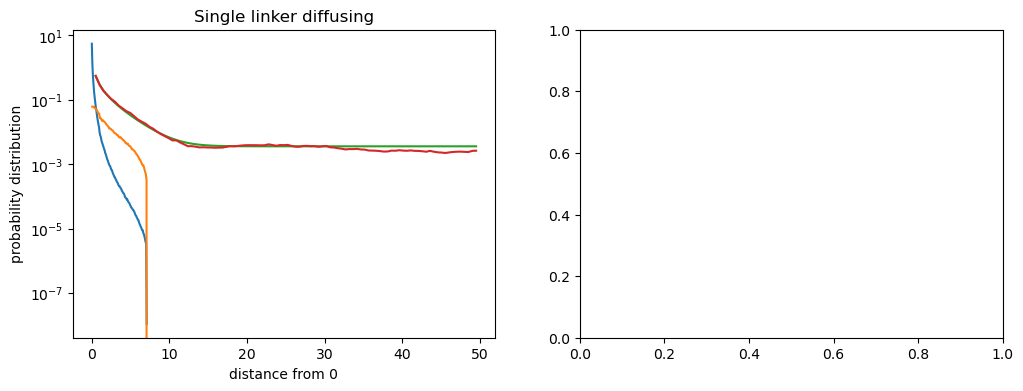

In [35]:
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
#ax[0].plot(Sim.get_X(Sim.PR.shape[0]),Sim.PR)
ax[0].plot(X_1,Y_1)
ax[0].plot(X_2,Y_2)
#ax[0].plot(X*R,PMatrix)
ax[0].set_xlabel('distance from 0')
ax[0].set_ylabel('probability distribution')
ax[0].set_title('Single linker diffusing')
#ax[1].plot(np.linspace(0,Sim.Gillespie.ell_tot,Sim.L_size,endpoint=False),Sim.PL)
ax[0].plot(X*R,PMatrix)
ax[0].plot(sssys.X(),sssys.PR)
ax[0].set_yscale('log')
#ax[1].plot(np.linspace(0.,sssys.L,sssys.N_L_points,endpoint=False),sssys.PL)

## do the same with 2 linkers

[3.213428273063625, 0.8458674008673728, 0.0, 1.8457932988787908, 2.6334446151943456]


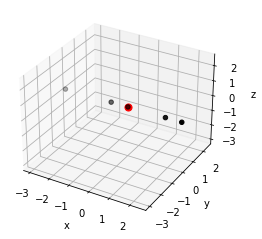

In [41]:
Sys = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=3,dimension=1)
Sys.Plot3DGillespie()
print([np.linalg.norm(r) for r in Sys.get_r()])

In [42]:
Sim = SimSys.Simulation(step_tot = 10**6,size=100,L_size=100,Gillespie = Sys)
Sim.simulate_eq_distribution()
print(Sim.move)

[0.484659 0.030678 0.       0.484663]


In [43]:
print(Sim.integrate_density(Sim.PR))

0.9999999999999734


0.9825846435462526


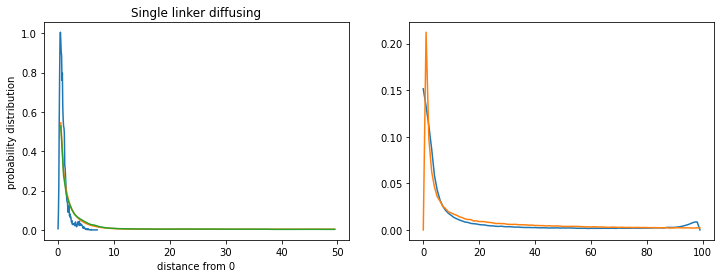

In [44]:
print(Sim.Mean_distance)
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot(Sim.get_X(Sim.PR.shape[0]),Sim.PR)
#ax[0].plot(X*R,PMatrix)
ax[0].set_xlabel('distance from 0')
ax[0].set_ylabel('probability distribution')
ax[0].set_title('Single linker diffusing')
ax[1].plot(np.linspace(0,Sim.Gillespie.ell_tot,Sim.L_size,endpoint=False),Sim.PL)
ax[0].plot(X*R,PMatrix)
ax[0].plot(sssys.X(),sssys.PR)
#ax[0].set_yscale('log')
ax[1].plot(np.linspace(0.,sssys.L,sssys.N_L_points,endpoint=False),sssys.PL)

## Real 3D

[0.0, 4.9270401343788865]


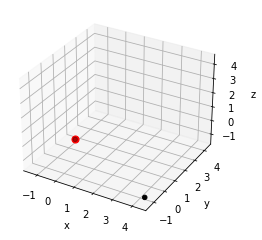

In [10]:
Sys = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=2,dimension=3)
Sys.Plot3DGillespie()
print([np.linalg.norm(r) for r in Sys.get_r()])

In [17]:
Sim = SimSys.Simulation(step_tot = 10**7,size=100,L_size=100,Gillespie = Sys)
Sim.simulate_eq_distribution()
print(Sim.move)

[0.2701534 0.4596932 0.        0.2701534]


In [20]:
print(Sim.integrate_density(Sim.PR))

0.999999999999921


3.4607817726725125


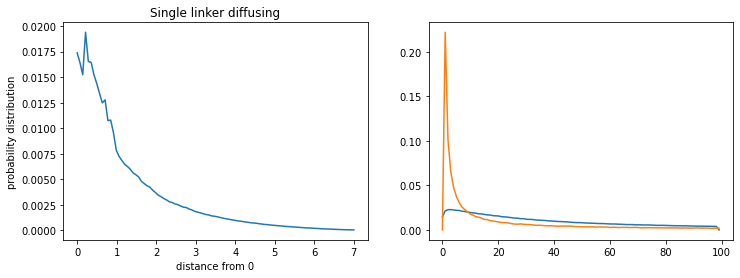

In [22]:
print(Sim.Mean_distance)
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot(Sim.get_X(Sim.PR.shape[0]),Sim.PR)
#ax[0].plot(X*R,PMatrix)
ax[0].set_xlabel('distance from 0')
ax[0].set_ylabel('probability distribution')
ax[0].set_title('Single linker diffusing')
ax[1].plot(np.linspace(0,Sim.Gillespie.ell_tot,Sim.L_size,endpoint=False),Sim.PL)
#ax[0].plot(X*R,PMatrix)
#ax[0].plot(sssys.X(),sssys.PR)
#ax[0].set_yscale('log')
ax[1].plot(np.linspace(0.,sssys.L,sssys.N_L_points,endpoint=False),sssys.PL)

## 3D 3 linkers

[6.785728857615254, 0.0, 4.816120415325206]


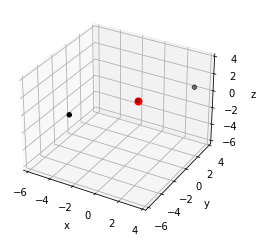

In [23]:
Sys = backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = np.random.randint(0,1000000),Nlinker=3,dimension=3)
Sys.Plot3DGillespie()
print([np.linalg.norm(r) for r in Sys.get_r()])

In [25]:
Sim = SimSys.Simulation(step_tot = 10**6,size=100,L_size=100,Gillespie = Sys)
Sim.simulate_eq_distribution()
print(Sim.move)

[0.380176 0.239648 0.       0.380176]


3.50764074856286


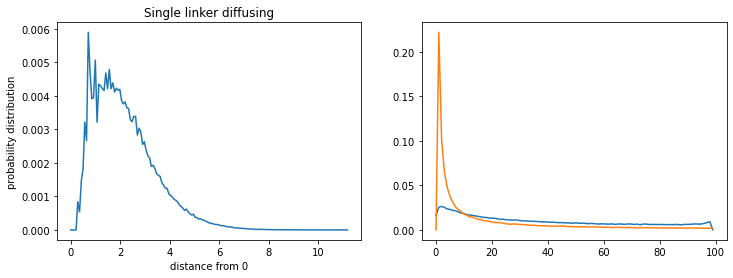

In [26]:
print(Sim.Mean_distance)
fig,ax = plt.subplots(ncols=2,figsize=(12,4))
ax[0].plot(Sim.get_X(Sim.PR.shape[0]),Sim.PR)
#ax[0].plot(X*R,PMatrix)
ax[0].set_xlabel('distance from 0')
ax[0].set_ylabel('probability distribution')
ax[0].set_title('Single linker diffusing')
ax[1].plot(np.linspace(0,Sim.Gillespie.ell_tot,Sim.L_size,endpoint=False),Sim.PL)
#ax[0].plot(X*R,PMatrix)
#ax[0].plot(sssys.X(),sssys.PR)
#ax[0].set_yscale('log')
ax[1].plot(np.linspace(0.,sssys.L,sssys.N_L_points,endpoint=False),sssys.PL)

## Run a serie of simulation for several value of the energy

In [113]:
import copy
p = Pool(10)
def pool_distrib(Eb,seed):
    Sys =  backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = seed,Nlinker=2)
    Sim = SimSys.Simulation(step_tot = 10**6,size=1000,Gillespie = Sys)
    Sim.simulate_eq_distribution()
    return copy.copy(Sim.PR),copy.copy(Sim.dr)

In [114]:
res = p.starmap(pool_distrib,zip(np.arange(-20,0,2.),np.array([np.random.randint(100000) for _ in range(10)])))

Process ForkPoolWorker-185:
Process ForkPoolWorker-180:
Process ForkPoolWorker-183:
Process ForkPoolWorker-184:
Process ForkPoolWorker-176:
Process ForkPoolWorker-181:
Process ForkPoolWorker-177:
Process ForkPoolWorker-179:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-178:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/hcleroy/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3197, in ndim
    return a.ndim
Traceback (most recent call last):
  File "/home/hcleroy/anaconda3/lib/

Process ForkPoolWorker-162:
Process ForkPoolWorker-161:
Process ForkPoolWorker-163:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hcleroy/anaconda3/lib/python3.8/multiprocessing/process.py", line 108,

KeyboardInterrupt: 

In [ ]:
def Vol(R) : 
    return np.arccos(-1)*4./3. * R**3
def integrate_density(P,dr):
    return np.sum([P[i]*(Vol(dr*(i+1))-Vol(dr*i)) for i in range(P.shape[0])])

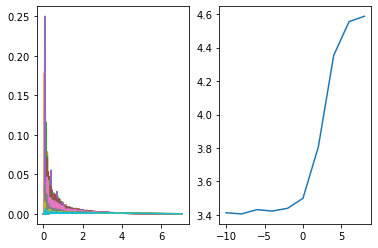

In [ ]:
fig,ax = plt.subplots(ncols=2)
for i in range(10):
    ax[0].plot(np.array([j*res[i][1] for j in range(res[i][0].shape[0])]), res[i][0])

ax[1].plot(np.arange(-10,10,2.),np.array([integrate_density(res[i][0]*np.array([j*res[i][1] for j in range(res[i][0].shape[0])]),res[i][1]) for i in range(10)]))

## Do the same with more linkers

In [128]:
import copy
p = Pool(10)
def pool_distrib_5_linkers(Eb,seed,ttot):
    Sys =  backend.Gillespie(ell_tot=L,rho0=0.,BindingEnergy=Eb,kdiff=kdiff*5,seed = seed,Nlinker=10)
    Sim = SimSys.Simulation(step_tot = ttot,size=1000,Gillespie = Sys)
    Sim.simulate_eq_distribution()
    return copy.copy(Sim.PR),copy.copy(Sim.dr)

In [137]:
N_replica = 30

In [138]:
res_4 = list()
for i in range(N_replica):np.zeros(self.N_L_points,dtype=float)          np.array([10**4 for _ in range(10)]))))

In [139]:
average_dr_4    =   np.array([
                    np.mean(np.array([
                        integrate_density(res_4[i][k][0]*np.array([j*res_4[i][k][1] for j in range(res_4[i][k][0].shape[0])]),res_4[i][k][1])
                        for i in range(N_replica)]))
                         for k in range(10)])

In [131]:
res_5 = list()
for i in range(10):
    res_5.append(   p.starmap(  pool_distrib_5_linkers  ,   zip(    np.arange(-30,0,3.),
                                                                    np.array([np.random.randint(100000) for _ in range(10)]),
                                                                    np.array([10**5 for _ in range(10)]))))

In [132]:
average_dr_5    =   np.array([
                    np.mean(np.array([
                        integrate_density(res_5[i][k][0]*np.array([j*res_5[i][k][1] for j in range(res_5[i][k][0].shape[0])]),res_5[i][k][1])
                        for i in range(10)]))
                         for k in range(10)])

In [142]:
res_6 = list()
for i in range(10):
    res_6.append(   p.starmap(  pool_distrib_5_linkers  ,   zip(    np.arange(-30,0,3.),
                                                                    np.array([np.random.randint(100000) for _ in range(10)]),
                                                                    np.array([10**6 for _ in range(10)]))))

In [143]:
average_dr_6    =   np.array([
                    np.mean(np.array([
                        integrate_density(res_6[i][k][0]*np.array([j*res_6[i][k][1] for j in range(res_6[i][k][0].shape[0])]),res_6[i][k][1])
                        for i in range(10)]))
                         for k in range(10)])

In [144]:
np.save('average_dr_6.npy',average_dr_6)

In [133]:
#res_6   =   p.starmap(  pool_distrib_5_linkers  ,   zip(    np.arange(-30,0,3.),
#                                                            np.array([np.random.randint(100000) for _ in range(10)]),
#                                                            np.array([10**6 for _ in range(10)])))

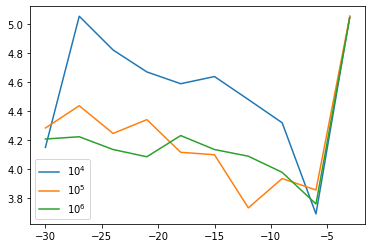

In [145]:
plt.plot(np.arange(-30,0,3.),average_dr_4,label=r'$10^4$')
plt.plot(np.arange(-30,0,3.),average_dr_5,label=r'$10^5$')
plt.plot(np.arange(-30,0,3.),average_dr_6,label=r'$10^6$')
#plt.plot(np.arange(-30,0,3.),np.array([integrate_density(res_6[i][0]*np.array([j*res_6[i][1] for j in range(res_6[i][0].shape[0])]),res_6[i][1]) for i in range(10)]),label=r'$10^6$')
plt.legend()


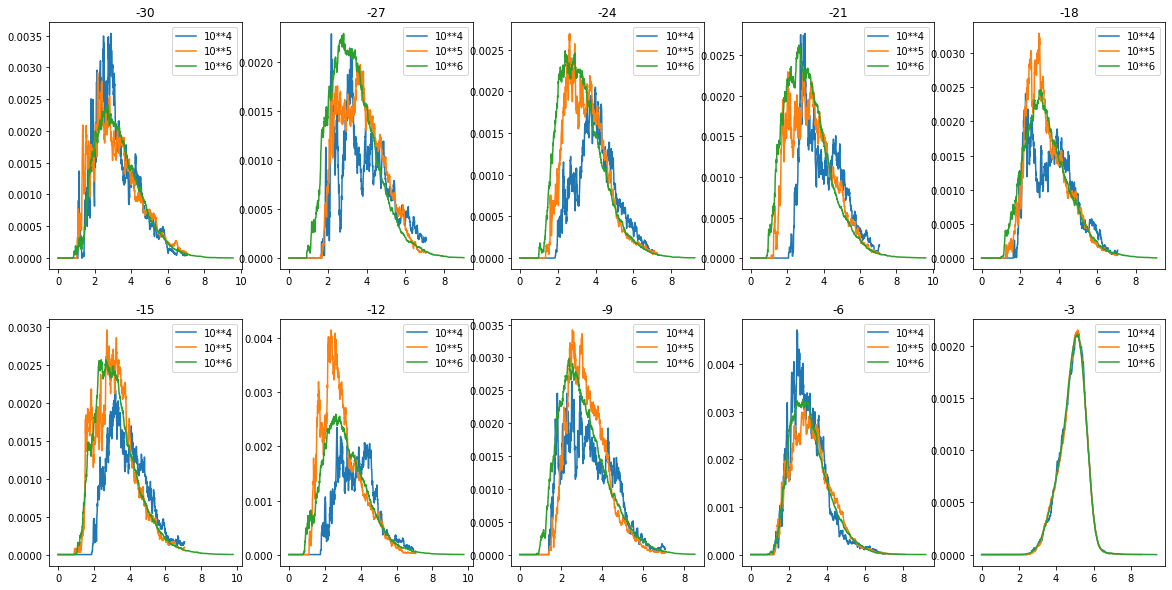

In [147]:
fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(20,10))
for i in range(10):
    min_size_4 = np.min([res_4[k][i][0].shape[0] for k in range(10)])
    min_size_5 = np.min([res_5[k][i][0].shape[0] for k in range(10)])
    min_size_6 = np.min([res_6[k][i][0].shape[0] for k in range(10)])

    I_min_size_4 = np.argmin([res_4[k][i][0].shape[0] for k in range(10)])
    I_min_size_5 = np.argmin([res_5[k][i][0].shape[0] for k in range(10)])
    I_min_size_6 = np.argmin([res_6[k][i][0].shape[0] for k in range(10)])

    ax[i//5,i%5].plot(  np.array([j*res_4[I_min_size_4][i][1] for j in range(res_4[I_min_size_4][i][0].shape[0])]), 
                        np.mean(np.array([uniform_filter1d(res_4[k][i][0],size=10)[:min_size_4] for k in range(N_replica)]),axis=0),label='10**4')
    ax[i//5,i%5].plot(  np.array([j*res_5[I_min_size_5][i][1] for j in range(res_5[I_min_size_5][i][0].shape[0])]), 
                        np.mean(np.array([uniform_filter1d(res_5[k][i][0],size=10)[:min_size_5] for k in range(10)]),axis=0),label='10**5')
    ax[i//5,i%5].plot(  np.array([j*res_6[I_min_size_6][i][1] for j in range(res_6[I_min_size_6][i][0].shape[0])]), 
                        np.mean(np.array([uniform_filter1d(res_6[k][i][0],size=10)[:min_size_6] for k in range(10)]),axis=0),label='10**6')
    #ax[i//5,i%5].plot(np.array([j*res_6[i][1] for j in range(res_6[i][0].shape[0])]), uniform_filter1d(res_6[i][0],size=10),label='10**6')
    ax[i//5,i%5].set_title(str(np.arange(-30,0,3)[i]))
    ax[i//5,i%5].legend()
#plt.ylim(-0.001,0.005)
#plt.xlim(0.,8)
#plt.legend()